In [1]:
!pip install pandas numpy scipy matplotlib seaborn xgboost scikit-learn linearmodels statsmodels shap plotly joblib pyarrow -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
# Create directory structure
DATA_DIR = Path("data")
OUTPUT_DIR = Path("output")
FIGURES_DIR = OUTPUT_DIR / "figures"
MODELS_DIR = OUTPUT_DIR / "models"

for d in [DATA_DIR, OUTPUT_DIR, FIGURES_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

In [4]:
# Google COVID-19 Open Data base URL
GCS_BASE = "https://storage.googleapis.com/covid19-open-data/v3"


In [18]:
def download_covid_data():
    """Download main tables from Google COVID-19 Open Data"""
    tables = {
        "epidemiology": f"{GCS_BASE}/epidemiology.csv",
        "mobility": f"{GCS_BASE}/mobility.csv",
        # Has a slightly different links
        "government_response": f"{GCS_BASE}/oxford-government-response.csv",
        "vaccination": f"{GCS_BASE}/vaccinations.csv"
    }
    
    for name, url in tables.items():
        parquet_path = DATA_DIR / f"{name}.parquet"
        
        if parquet_path.exists():
            print(f" {name}.parquet already exists, skipping download")
            continue
            
        print(f" Downloading {name}... (this may take a few minutes)")
        try:
            df = pd.read_csv(url, parse_dates=["date"])
            df.to_parquet(parquet_path, index=False)
            print(f"  Saved {len(df):,} rows to {parquet_path}")
        except Exception as e:
            print(f"  Error downloading {name}: {e}")
            print(f"  You may need to download manually from: {url}")
    
    print("\n Data download complete!")

In [19]:
download_covid_data()

 epidemiology.parquet already exists, skipping download
 mobility.parquet already exists, skipping download
  Saved 303,969 rows to data\government_response.parquet
  Saved 2,545,118 rows to data\vaccination.parquet

 Data download complete!


In [8]:
def load_and_merge_tables():
    """Load parquet files and merge into single panel dataframe"""
    print("Loading tables...")
    
    # Load epidemiology data
    epi = pd.read_parquet(DATA_DIR / "epidemiology.parquet")
    print(f"  Epidemiology: {len(epi):,} rows, {len(epi['location_key'].unique()):,} locations")
    
    # Load mobility data
    mobi = pd.read_parquet(DATA_DIR / "mobility.parquet")
    print(f"  Mobility: {len(mobi):,} rows, {len(mobi['location_key'].unique()):,} locations")
    
    # Load government response data
    gov = pd.read_parquet(DATA_DIR / "government_response.parquet")
    print(f"  Government Response: {len(gov):,} rows, {len(gov['location_key'].unique()):,} locations")
    
    # Select relevant columns
    epi_cols = ["location_key", "date", "new_confirmed", "total_confirmed", 
                "new_deceased", "new_tested", "population"]
    mobi_cols = ["location_key", "date", "workplaces_percent_change_from_baseline",
                 "transit_stations_percent_change_from_baseline",
                 "residential_percent_change_from_baseline"]
    gov_cols = ["location_key", "date", "school_closing", "workplace_closing",
                "stay_at_home_requirements", "restrictions_on_gatherings", 
                "stringency_index"]
    
    # Filter to available columns
    epi_cols = [c for c in epi_cols if c in epi.columns]
    mobi_cols = [c for c in mobi_cols if c in mobi.columns]
    gov_cols = [c for c in gov_cols if c in gov.columns]
    
    epi = epi[epi_cols]
    mobi = mobi[mobi_cols]
    gov = gov[gov_cols]
    
    # Merge
    print("\nMerging tables...")
    df = epi.merge(mobi, on=["location_key", "date"], how="left")
    df = df.merge(gov, on=["location_key", "date"], how="left")
    
    # Sort by location and date
    df = df.sort_values(["location_key", "date"]).reset_index(drop=True)
    
    print(f" Merged dataframe: {len(df):,} rows, {len(df.columns)} columns")
    return df


In [10]:
def add_derived_features(df):
    """Add rolling averages, growth rates, and lagged features"""
    print("\nCreating derived features...")
    
    # 7-day rolling average of new cases
    df["cases_7d_avg"] = df.groupby("location_key")["new_confirmed"].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )
    
    # 7-day sum
    df["cases_7d_sum"] = df.groupby("location_key")["new_confirmed"].transform(
        lambda x: x.rolling(7, min_periods=1).sum()
    )
    
    # Growth rate: (today / 7 days ago) - 1
    df["cases_7d_lag"] = df.groupby("location_key")["new_confirmed"].shift(7)
    df["growth_7d"] = (df["new_confirmed"] / df["cases_7d_lag"].replace(0, np.nan)) - 1
    
    # Clip extreme growth rates
    df["growth_7d"] = df["growth_7d"].clip(-1, 10)
    
    # Future values for prediction (10-day lead)
    df["future_cases_10d"] = df.groupby("location_key")["new_confirmed"].shift(-10)
    df["future_growth_10d"] = (
        df["future_cases_10d"] / df["cases_7d_lag"].replace(0, np.nan)
    ) - 1
    df["future_growth_10d"] = df["future_growth_10d"].clip(-1, 10)
    
    # Log cases for alternative specification
    df["log_cases"] = np.log1p(df["new_confirmed"])
    
    print(f" Added derived features")
    return df

In [11]:
def create_treatment_variables(df, policy_col="school_closing", threshold=2):
    """
    Create binary treatment indicator and event time variables
    
    Parameters:
    - policy_col: name of policy column (e.g., 'school_closing')
    - threshold: value at which policy is considered "on" (e.g., >= 2)
    """
    print(f"\nCreating treatment variables for: {policy_col} >= {threshold}")
    
    # Binary indicator: policy is "on"
    df["policy_on"] = (df[policy_col] >= threshold).astype(int)
    
    # Find first treatment date per location
    treated = df[df["policy_on"] == 1].groupby("location_key")["date"].min()
    treated = treated.rename("treatment_date")
    
    df = df.merge(treated, on="location_key", how="left")
    
    # Event time: days since treatment (negative = before treatment)
    df["event_time"] = (df["date"] - df["treatment_date"]).dt.days
    
    # Treatment status
    n_treated = df["treatment_date"].notna().sum()
    n_total = len(df["location_key"].unique())
    pct_treated = (df["treatment_date"].notna().sum() / len(df["location_key"].unique())) * 100
    
    print(f"  Treatment defined as: {policy_col} >= {threshold}")
    print(f"  Locations ever treated: {df['treatment_date'].notna().value_counts().get(True, 0):,} / {len(df['location_key'].unique()):,}")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    
    return df

In [20]:
# Execute preprocessing pipeline
df = load_and_merge_tables()
df = add_derived_features(df)
df = create_treatment_variables(df, policy_col="school_closing", threshold=2)

Loading tables...
  Epidemiology: 12,525,825 rows, 20,906 locations
  Mobility: 6,321,226 rows, 7,351 locations
  Government Response: 303,969 rows, 356 locations

Merging tables...
 Merged dataframe: 12,525,825 rows, 10 columns

Creating derived features...


c:\Users\Isaac IK\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Isaac IK\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


 Added derived features

Creating treatment variables for: school_closing >= 2
  Treatment defined as: school_closing >= 2
  Locations ever treated: 317,419 / 20,906
  Date range: 2019-12-31 00:00:00 to 2022-12-30 00:00:00


In [21]:
# Save processed panel
panel_path = DATA_DIR / "panel.parquet"
df.to_parquet(panel_path, index=False)
print(f"\n Saved processed panel to: {panel_path}")


 Saved processed panel to: data\panel.parquet


In [25]:
df.columns

Index(['location_key', 'date', 'new_confirmed', 'new_deceased', 'new_tested',
       'school_closing', 'workplace_closing', 'stay_at_home_requirements',
       'restrictions_on_gatherings', 'stringency_index', 'cases_7d_avg',
       'cases_7d_sum', 'cases_7d_lag', 'growth_7d', 'future_cases_10d',
       'future_growth_10d', 'log_cases', 'policy_on', 'treatment_date',
       'event_time'],
      dtype='object')

In [ ]:
# Load mobility data
mobi = pd.read_parquet(DATA_DIR / "mobility.parquet")
print(f"  Mobility: {len(mobi):,} rows, {len(mobi['location_key'].unique()):,} locations")



'''ArithmeticError
mobi_cols = ["location_key", "date", "workplaces_percent_change_from_baseline",
            "transit_stations_percent_change_from_baseline",
                 "residential_percent_change_from_baseline"]
                 '''

  Mobility: 6,321,226 rows, 7,351 locations


'ArithmeticError\nmobi_cols = ["location_key", "date", "workplaces_percent_change_from_baseline",\n            "transit_stations_percent_change_from_baseline",\n                 "residential_percent_change_from_baseline"]\n                 '

In [28]:
mobi.columns

Index(['date', 'location_key', 'mobility_retail_and_recreation',
       'mobility_grocery_and_pharmacy', 'mobility_parks',
       'mobility_transit_stations', 'mobility_workplaces',
       'mobility_residential'],
      dtype='object')

In [29]:
# Display summary statistics
print("DATA SUMMARY")
summary_cols = ["new_confirmed", "cases_7d_avg", "growth_7d", "policy_on", 
                "stringency_index", "new_tested"]
summary_cols = [c for c in summary_cols if c in df.columns]
print(df[summary_cols].describe())

DATA SUMMARY
       new_confirmed  cases_7d_avg     growth_7d     policy_on  \
count   1.247580e+07  1.247861e+07  7.170877e+06  1.252582e+07   
mean    1.111905e+02  1.099245e+02  2.650096e-01  1.063435e-02   
std     1.165983e+04  2.828263e+03  1.720168e+00  1.025732e-01   
min    -5.045418e+06 -7.200410e+05 -1.000000e+00  0.000000e+00   
25%     0.000000e+00  2.857143e-01 -6.666667e-01  0.000000e+00   
50%     1.000000e+00  2.285714e+00 -1.379310e-01  0.000000e+00   
75%     1.100000e+01  1.300000e+01  4.634146e-01  0.000000e+00   
max     5.047094e+06  7.783541e+05  1.000000e+01  1.000000e+00   

       stringency_index    new_tested  
count     279485.000000  3.194489e+06  
mean          49.661311  2.509508e+03  
std           22.433059  2.955847e+05  
min            0.000000 -3.541552e+08  
25%           34.260000  1.000000e+00  
50%           50.930000  7.000000e+00  
75%           66.670000  5.200000e+01  
max          100.000000  3.541856e+08  


In [31]:


from linearmodels.panel import PanelOLS
import statsmodels.api as sm

def run_panel_fe_regression(df, outcome="growth_7d", policy_lag=10):
    """
    Run panel fixed effects regression with entity and time effects
    
    Model: Y_it = β*Policy_i,t-lag + X_it + α_i + γ_t + ε_it
    """
    print(f"\nRunning Panel FE with {policy_lag}-day policy lag...")
    
    # Create lagged policy variable
    df = df.copy()
    df["policy_lag"] = df.groupby("location_key")["policy_on"].shift(policy_lag)
    
    # Select complete cases
    reg_vars = [outcome, "policy_lag", "stringency_index", "new_tested", 
                "location_key", "date"]
    reg_vars = [v for v in reg_vars if v in df.columns]
    
    df_reg = df[reg_vars].dropna()
    
    print(f"  Sample size: {len(df_reg):,} observations")
    print(f"  Locations: {df_reg['location_key'].nunique():,}")
    print(f"  Time periods: {df_reg['date'].nunique():,}")
    
    # Set panel index
    df_reg = df_reg.set_index(["location_key", "date"])
    
    # Prepare regressors
    X_cols = ["policy_lag", "stringency_index"]
    if "new_tested" in df_reg.columns:
        X_cols.append("new_tested")
    
    X = df_reg[X_cols].fillna(0)
    X = sm.add_constant(X)
    y = df_reg[outcome]
    
    # Fit model with two-way fixed effects
    model = PanelOLS(y, X, entity_effects=True, time_effects=True)
    results = model.fit(cov_type="clustered", cluster_entity=True)
    
    print("\n" + "-"*80)
    print("REGRESSION RESULTS")
    print("-"*80)
    print(results.summary)
    
    # Extract key coefficient
    if "policy_lag" in results.params.index:
        coef = results.params["policy_lag"]
        se = results.std_errors["policy_lag"]
        pval = results.pvalues["policy_lag"]
        ci_lower = coef - 1.96 * se
        ci_upper = coef + 1.96 * se
        
        print("\n" + "="*80)
        print("KEY FINDING")
        print("="*80)
        print(f"Policy effect (β): {coef:.4f}")
        print(f"Standard error: {se:.4f}")
        print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
        print(f"P-value: {pval:.4f}")
        print(f"Interpretation: Policy (lagged {policy_lag} days) is associated with")
        print(f"a {coef*100:.2f}% change in 7-day case growth rate")
        print("="*80)
    
    return results, df_reg


In [32]:
print("\n" + "="*80)
print("SECTION 3: PANEL FIXED EFFECTS REGRESSION")
print("="*80)

# Run regression
results_fe, df_reg = run_panel_fe_regression(df, outcome="growth_7d", policy_lag=10)



SECTION 3: PANEL FIXED EFFECTS REGRESSION

Running Panel FE with 10-day policy lag...
  Sample size: 120,574 observations
  Locations: 262
  Time periods: 929

--------------------------------------------------------------------------------
REGRESSION RESULTS
--------------------------------------------------------------------------------
                          PanelOLS Estimation Summary                           
Dep. Variable:              growth_7d   R-squared:                        0.0033
Estimator:                   PanelOLS   R-squared (Between):             -0.2371
No. Observations:              120574   R-squared (Within):               0.0011
Date:                Fri, Dec 12 2025   R-squared (Overall):             -0.0019
Time:                        13:53:49   Log-likelihood                -1.874e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      129.87
Entities: 

In [33]:
def run_event_study(df, max_lead=20, max_lag=40, outcome="growth_7d"):
    """
    Event study / dynamic DiD specification
    
    Estimates effects at different event times relative to treatment
    """
    print(f"\nPreparing event study with leads={max_lead}, lags={max_lag}...")
    
    df = df.copy()
    
    # Keep only observations with valid event time
    df = df[df["event_time"].notna()].copy()
    
    # Clip event time
    df["event_time_clip"] = df["event_time"].clip(-max_lead, max_lag)
    
    # Create event time dummies
    event_dummies = pd.get_dummies(df["event_time_clip"], prefix="event", dtype=int)
    df = pd.concat([df, event_dummies], axis=1)
    
    # Drop reference period (t = -1)
    ref_col = "event_-1"
    event_cols = [c for c in event_dummies.columns if c != ref_col]
    
    print(f"  Event time dummies: {len(event_cols)}")
    print(f"  Sample size: {len(df):,}")
    
    # Prepare for regression
    reg_vars = [outcome, "location_key", "date"] + event_cols
    if "stringency_index" in df.columns:
        reg_vars.append("stringency_index")
    
    df_event = df[reg_vars].dropna()
    df_event = df_event.set_index(["location_key", "date"])
    
    # Controls
    X_cols = event_cols.copy()
    if "stringency_index" in df_event.columns:
        X_cols.append("stringency_index")
    
    X = df_event[X_cols].fillna(0)
    X = sm.add_constant(X)
    y = df_event[outcome]
    
    # Fit model
    print("\n  Estimating event study model...")
    model = PanelOLS(y, X, entity_effects=True, time_effects=True)
    results = model.fit(cov_type="clustered", cluster_entity=True)
    
    # Extract event coefficients
    event_coefs = []
    for col in event_cols:
        if col in results.params.index:
            event_time = int(col.replace("event_", ""))
            coef = results.params[col]
            se = results.std_errors[col]
            ci_lower = coef - 1.96 * se
            ci_upper = coef + 1.96 * se
            event_coefs.append({
                "event_time": event_time,
                "coef": coef,
                "se": se,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper
            })
    
    event_df = pd.DataFrame(event_coefs).sort_values("event_time")
    
    print("✓ Event study complete")
    return results, event_df


In [34]:
print("\n" + "="*80)
print("SECTION 4: EVENT STUDY ANALYSIS")
print("="*80)
# Run event study
results_event, event_coefs = run_event_study(df, max_lead=20, max_lag=40)



SECTION 4: EVENT STUDY ANALYSIS

Preparing event study with leads=20, lags=40...
  Event time dummies: 61
  Sample size: 317,419

  Estimating event study model...


ValueError: exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False.

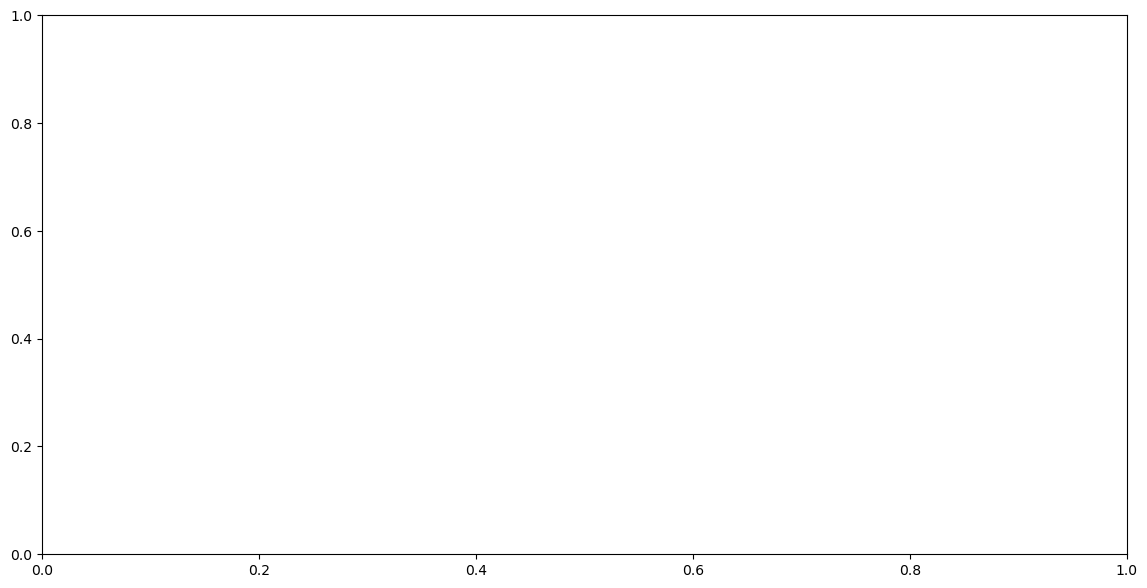

In [35]:
# Plot event study
fig, ax = plt.subplots(figsize=(14, 7))